#Analyzing the NYC Subway Dataset
#Intro to Data Science: Final Project 1, Part 2  
#(Short Questions)
##Section 2. Linear Regression
Austin J. Alexander
***

##Import Directives and Initial DataFrame Creation

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import statsmodels.api as sm
import scipy.optimize as op

import matplotlib.pyplot as plt
%matplotlib inline

filename = '/Users/excalibur/py/nanodegree/intro_ds/final_project/improved-dataset/turnstile_weather_v2.csv'

# import data
data = pd.read_csv(filename)
print data.columns.values

['UNIT' 'DATEn' 'TIMEn' 'ENTRIESn' 'EXITSn' 'ENTRIESn_hourly'
 'EXITSn_hourly' 'datetime' 'hour' 'day_week' 'weekday' 'station'
 'latitude' 'longitude' 'conds' 'fog' 'precipi' 'pressurei' 'rain' 'tempi'
 'wspdi' 'meanprecipi' 'meanpressurei' 'meantempi' 'meanwspdi'
 'weather_lat' 'weather_lon']


In [2]:
data['ENTRIESn_hourly'].describe()

count    42649.000000
mean      1886.589955
std       2952.385585
min          0.000000
25%        274.000000
50%        905.000000
75%       2255.000000
max      32814.000000
Name: ENTRIESn_hourly, dtype: float64

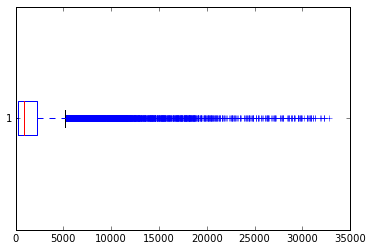

In [3]:
plt.boxplot(data['ENTRIESn_hourly'], vert=False)
plt.show()

In [4]:
data[data['ENTRIESn_hourly'] == 0].count()[0]

897

In [5]:
data[data['ENTRIESn_hourly'] > 500].count()[0]

27586

In [6]:
data[data['ENTRIESn_hourly'] > 1000].count()[0]

20052

In [7]:
data[data['ENTRIESn_hourly'] > 5000].count()[0]

3664

In [8]:
data[data['ENTRIESn_hourly'] > 10000].count()[0]

1174

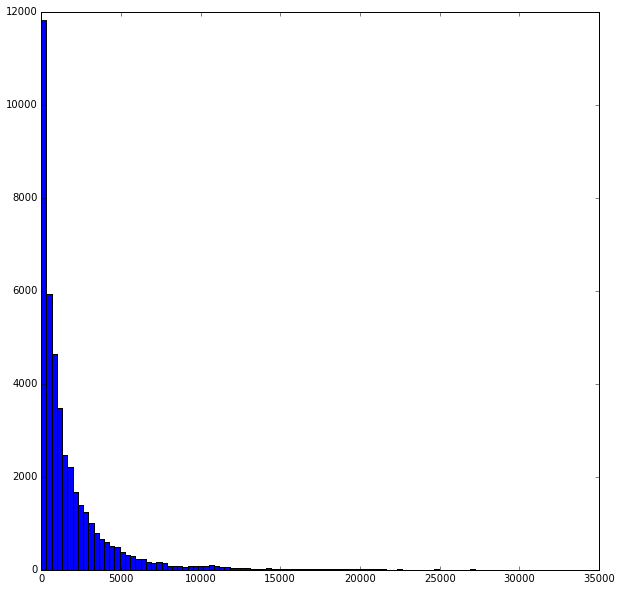

In [9]:
plt.figure(figsize = (10,10))
plt.hist(data['ENTRIESn_hourly'], bins=100)
plt.show()

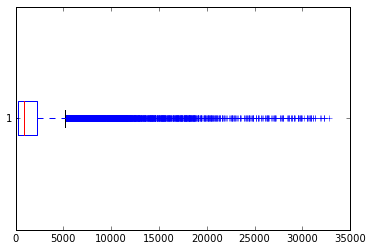

In [10]:
plt.boxplot(data['ENTRIESn_hourly'], vert=False)
plt.show()

In [11]:
# the overwhelming majority of the action is occurring below 10000
#data = data[(data['ENTRIESn_hourly'] <= 10000)]

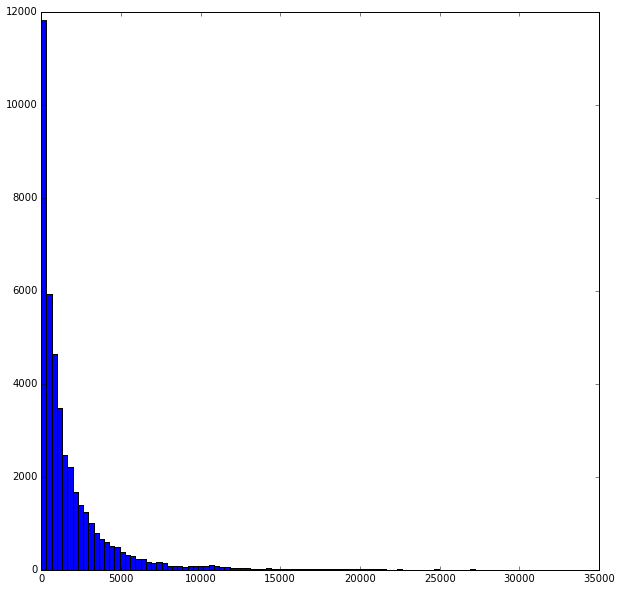

In [12]:
plt.figure(figsize = (10,10))
plt.hist(data['ENTRIESn_hourly'].values, bins=100)
plt.show()

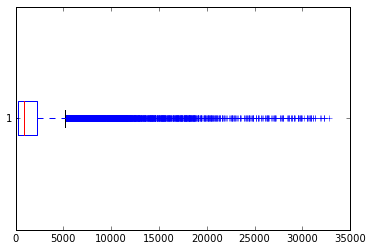

In [13]:
plt.boxplot(data['ENTRIESn_hourly'].values, vert=False)
plt.show()

##Class for Creating Training and Testing Samples

In [14]:
class SampleCreator:
    
    def __init__(self,data,categorical_features,quantitative_features):
        m = data.shape[0]
        random_indices = np.random.choice(np.arange(0,m), size=m, replace=False)
        train_indices = random_indices[0:(m-(m*0.10))] # leave about 10% of data for testing
        test_indices = random_indices[(m-(m*0.10)):]
        # check disjointedness of training and testing indices
        for i in train_indices:
            if i in test_indices:
                print "<!> Training and Testing Sample Overlap <!>"
        
        # response vector
        y = data['ENTRIESn_hourly'].values
        
        # get quantitative features
        X = data[quantitative_features].values
        
        # Feature Scaling
        # mean normalization
        x_i_bar = []
        s_i = []

        for i in np.arange(X.shape[1]):
            x_i_bar.append(np.mean(X[:,i]))
            s_i.append(np.std(X[:,i]))

            X[:,i] = np.true_divide((np.subtract(X[:,i],x_i_bar[i])),s_i[i])
        
        # create dummy variables for categorical features
        for feature in categorical_features:
            dummies = sm.categorical(data[feature].values, drop=True)
            X = np.hstack((X,dummies))

        # final design matrix
        X = sm.add_constant(X)

        # training samples
        self.y_train = y[train_indices]
        self.X_train = X[train_indices]

        # testing samples
        self.y_test = y[test_indices]
        self.X_test = X[test_indices]

##Section 2. Linear Regression

<h3 id='2_1'>2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model?</h3>



#####Notes
<sup>1</sup> The linear correlation coefficient ($r$) can take on the following values: $-1 \leq r \leq 1$. If $r = +1$, then a perfect positive linear relation exists between the explanatory and response variables. If $r = -1$, then a perfect negative linear relation exists between the explanatory and response variables.

<sup>2</sup> The coefficient of determination ($R^{2}$) can take on the following values: $0 \leq R^{2} \leq 1$. If $R^{2} = 0$, the least-squares regression line has no explanatory value; if $R^{2} = 1$, the least-squares regression line explains $100\%$ of the variation in the response variable.

<h3 id='2_2'>2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?</h3>

Quantitative features used: 'hour','day_week','rain','tempi'.

Categorical features used: 'UNIT'. As a categorical feature, this variable required the use of so-called dummy variables.

<h3 id='2_3'>2.3 Why did you select these features in your model?</h3>

Due to the findings presented in the <a href='IntroDS-ProjectOne-DataExploration-Supplement.ipynb' target='_blank'>*DataExploration* supplement</a>, it seemed clear that location significantly impacted the number of entries. In addition, the hour and day of the week showed importance. Temperature appeared to have some relationship with entries as well, and so it was included. Based on that exploration and on the statistical and practical evidence offered in <a href='IntroDS-ProjectOne-Section1.ipynb' target='_blank'>Section 1. Statistical Test</a>, rain was not included as a feature (and, as evidenced by a number of test runs, had marginal if any importance).


As far as the selection of location and day/time variables were concerned, **station** can be captured quantitatively by **latitude** and **longitude**, both of which, as numeric values, should offer a better sense of trend toward something. However, as witnessed by numerous test runs, **latitude** and **longitude** in fact appear to be redundant when using **UNIT** as a feature, which is in fact more signficant (as test runs indicated and, as one might assume, due to, for example, station layouts) than **latitude** and **longitude**.

Each **DATEn** is a 'one-off', so it's unclear how any could be helpful for modeling/predicting (as those dates literally never occur again). **day_week** seemed to be a better selection in this case.

####Using StatsModels OLS to Create a Model

In [15]:
#categorical_features = ['UNIT', 'hour', 'day_week', 'station']
categorical_features = ['UNIT']
#quantitative_features = ['latitude', 'longitude', 'rain']
quantitative_features = []

# for tracking during trials
best_rsquared = 0
best_results = []

# perform 5 trials; keep model with best R^2 
for x in xrange(0,5):
    samples = SampleCreator(data,categorical_features,quantitative_features)
    model = sm.OLS(samples.y_train,samples.X_train)
    results = model.fit()
    if results.rsquared > best_rsquared:
        best_rsquared = results.rsquared
        best_results = results
        
print "r = {0:.2f}".format(np.sqrt(best_results.rsquared))
print "R^2 = {0:.2f}".format(best_results.rsquared)

r = 0.61
R^2 = 0.38


Only categorical: day_week r = 0.24, hour r = 0.41, station r = 0.58, unit = 0.61 (adding conds does nothing: r = 0.74)

without rain: r = 0.74, with rain: r = 0.74

only quantitative: rain r = 0.74, which meant i didn't have to bother checking lat and long

no quantitative: 0.74

unit makes intuitive sense

as expected, inlcuding  'fog', 'precipi','pressurei', 'tempi',
 'wspdi', 'meanprecipi', 'meanpressurei', 'meantempi', 'meanwspdi',
 'weather_lat', 'weather_lon' did thing (r = 0.74)

####Get Training and Testing Values

In [16]:
X_train = samples.X_train
print X_train.shape
y_train = samples.y_train
print y_train.shape
y_train.shape = (y_train.shape[0],1)
print y_train.shape

X_test = samples.X_test
print X_test.shape
y_test = samples.y_test
print y_test.shape
y_test.shape = (y_test.shape[0],1)
print y_test.shape

(38384, 241)
(38384,)
(38384, 1)
(4265, 241)
(4265,)
(4265, 1)


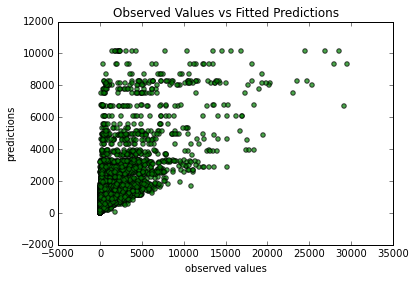

In [17]:
ols_y_hat = results.predict(X_test)
ols_y_hat.shape = (ols_y_hat.shape[0],1)

plt.title('Observed Values vs Fitted Predictions')
plt.xlabel('observed values')
plt.ylabel('predictions')
plt.scatter(y_test, ols_y_hat, alpha=0.7, color='green', edgecolors='black')
plt.show()

<h3 id='2_4'>2.4 What are the coefficients (or weights) of the features in your linear regression model?</h3>

In [18]:
print best_results.params

[ -3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14   3.00101611e+14   3.00101611e+14
   3.00101611e+14   3.00101611e+14

<h3 id='2_5'>2.5 What is your model’s $R^{2}$ (coefficient of determination) value?</h3>

For $n = 500$, the best $R^{2}$ value witnessed was $0.85$ (with the best $r$ value seen at $0.92$).

<h3 id='2_6_a'>2.6.a What does this $R^{2}$ value mean for the goodness of fit for your regression model?</h3>

This $R^{2}$ value means that $85\%$ of the proportion of total variation in the response variable is explained by the least-squares regression line (i.e., model) that was created above.

<h3 id='2_6_b'>2.6.b Do you think this linear model to predict ridership is appropriate for this dataset, given this $R^{2}$ value?</h3>

It's better than guessing in the dark, but too much shouldn't be staked on its predictions:

####Predictions and their Residual Differences from Observed Values

In [19]:
ols_residuals = (ols_y_hat - y_test)
ols_residuals.shape

(4265, 1)

As can be seen from the above, somewhat arbitrarily-selected, values, the number of *close* predictions is a little over $50\%$ when *close* is defined as a prediction with a difference that is less than $1$ from the actual observed value. Given that the value of entries can take on such a large range of values $[0, 32814]$, differences less than $100$ and $1000$ are shown as well. 

####Residual Analysis

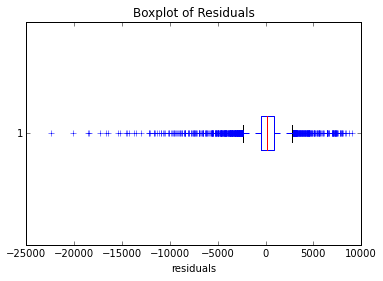

In [20]:
plt.boxplot(ols_residuals, vert=False)
plt.title('Boxplot of Residuals')
plt.xlabel('residuals')
plt.show()

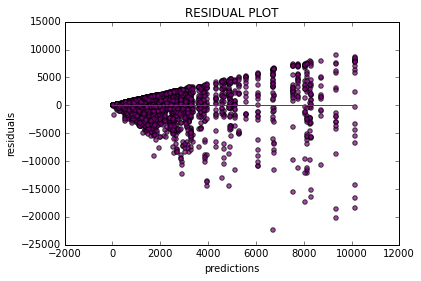

In [21]:
plt.scatter(ols_y_hat,ols_residuals, alpha=0.7, color='purple', edgecolors='black')
plt.title('RESIDUAL PLOT')
plt.plot([np.min(ols_y_hat),np.max(ols_y_hat)], [0, 0], color='red')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.show()

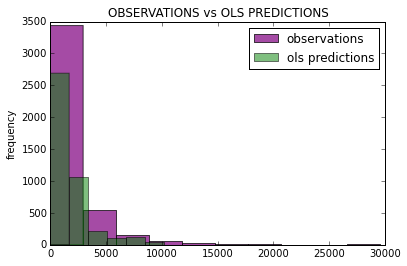

In [22]:
plt.hist(y_test, color='purple', alpha=0.7, label='observations')
plt.hist(ols_y_hat, color='green', alpha=0.5, bins=6, label='ols predictions')
plt.title('OBSERVATIONS vs OLS PREDICTIONS')
plt.ylabel('frequency')
plt.legend()
plt.show()

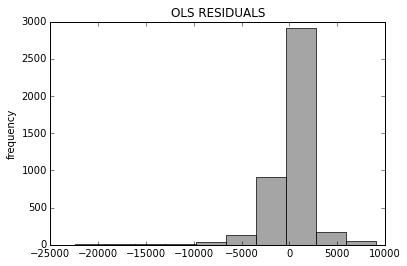

In [ ]:
plt.hist(ols_residuals, color='gray', alpha=0.7)
plt.title('OLS RESIDUALS')
plt.ylabel('frequency')
plt.show()

Since the above predictions show a discernible, linear, and increasing pattern (and, thus, are not stochastic), it seems apparent that there is in fact not a linear relationship between the explanatory and response variables. Thus, a linear model is not appropriate for the current data set.

In [ ]:
best_results.summary()

***

###Gradient Descent

In [ ]:
#gradient descent, number of iterations
#iterations = 100
iterations = 300

# learning rates 
#alpha = [-0.3, -0.1, -0.03, -0.01, -0.003, -0.001, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
#alpha = [0.001] # before removing large values
alpha = [0.01]

# number of examples
m = X_train.shape[0]
print "m = {0}".format(m)

# number of features
n = X_train.shape[1]
print "n = {0}".format(n)

# theta parameters
theta = np.zeros(((n,1)))

# vectorized cost function
def J(X,y):
    m = X.shape[0]
    return (1.0/(2*m)) * (((X.dot(theta)) - y).T).dot(X.dot(theta) - y)

# vectorized delta function
def delta(X,y):
    return X.T.dot((X.dot(theta)) - y)

In [ ]:
# gradient descent, test multiple alphas
for a in np.arange(0,len(alpha)):
    
    # reset theta
    theta = np.zeros(((n),1))
    
    # reset vector J_values, store cost function values for plotting
    J_values = np.zeros((iterations,1))
    
    # minibatch process
    for i in np.arange(0,m,100):
        for iteration in xrange(0,iterations):
            X = X_train[i:i+100]
            y = y_train[i:i+100]
            
            theta = theta - (alpha[a] * delta(X,y))
            J_values[iteration] = J(X,y)
    
    # visualize the cost function (2-D)
    cost_x = np.arange(iterations)
    cost_x.shape = (iterations,1)
    plt.plot(cost_x,J_values)
    plt.title("Learning Rate: " + str(alpha[a]))
    plt.xlabel('iterations')
    plt.ylabel(r"$J(\theta)$")
    plt.show()

In [ ]:
print "Parameters:\n{0}\n...".format(theta[0:5])

In [ ]:
grad_desc_y_hat = X_test.dot(theta)
print grad_desc_y_hat.shape

In [ ]:
plt.title('Observed Values vs Fitted Predictions')
plt.xlabel('observed values')
plt.ylabel('predictions')
plt.scatter(y_test, grad_desc_y_hat, alpha=0.7, color='green', edgecolors='black')
plt.show()

In [ ]:
gd_residuals = (grad_desc_y_hat - y_test)
gd_residuals.shape

In [ ]:
plt.boxplot(gd_residuals, vert=False)
plt.title('Boxplot of Residuals')
plt.xlabel('residuals')
plt.show()

In [ ]:
plt.scatter(grad_desc_y_hat,gd_residuals, alpha=0.7, color='purple', edgecolors='black')
plt.title('RESIDUAL PLOT')
plt.plot([np.min(grad_desc_y_hat),np.max(grad_desc_y_hat)], [0, 0], color='red')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.show()

In [ ]:
gd_rounded_yhat = np.round(grad_desc_y_hat)
for i in np.arange(y_test.shape[0]):
    if gd_rounded_yhat[i] == y_test[i]:
        print gd_rounded_yhat[i]

In [ ]:
plt.hist(y_test, color='purple', alpha=0.7, label='observations')
plt.hist(grad_desc_y_hat, color='green', alpha=0.5, label='gd predictions')
plt.title('OBSERVATIONS vs GD PREDICTIONS')
plt.ylabel('frequency')
plt.show()

In [ ]:
plt.hist(gd_residuals, color='gray', alpha=0.7)
plt.title('GD RESIDUALS')
plt.ylabel('frequency')
plt.show()

In [ ]:
def grad_desc_score():
    within_50 = 0
    for i in range(len(y_test)):
        if np.absolute(y_test[i] - grad_desc_y_hat[i]) <= 1000:
            within_50 += 1
    
    return within_50*1.0/len(y_test)
        
grad_desc_score()

In [ ]:
X_test[0:5]

regression makes little sense here

negative values are complete garbage

fractional values mean nothing

moreover, humans tend to care about ranges when it comes to numbers like these, not exact values

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, n_jobs=-1) # 10, 30, 100, 300
clf = clf.fit(X_train,np.ravel(y_train))

In [ ]:
units = data['UNIT'].values
entries = data['ENTRIESn_hourly'].values
units = np.array([int(u.replace('R','')) for u in units])
units.shape = (units.shape[0],1)

In [ ]:
clf = RandomForestClassifier(n_estimators = 10, n_jobs=-1) # 10, 30, 100, 300
clf = clf.fit(units,entries)

In [ ]:
pred = clf.predict(units)
clf.score(units,entries)

print y_test_classes[0:10]
print pred[0:10]

plt.hist([int(i) for i in y_test_classes], bins=20, alpha=0.7, color='blue')
plt.hist([int(i) for i in pred], bins=20, alpha=0.7, color='green')
plt.show()

len([int(i) for i in pred])

plt.scatter([int(i) for i in y_test_classes],[int(i) for i in pred], alpha=0.7)
plt.show()

count = 0
correct = []
wrong = []

for i in range(len(y_test_classes)):
    if int(y_test_classes[i]) == int(pred[i]):
        correct.append(pred[i])
        count += 1
    else:
        wrong.append(pred[i])
        
print count

plt.hist([int(i) for i in wrong], bins=20, alpha=0.5, color='gray')
plt.hist([int(i) for i in correct], bins=20, alpha=0.5, color='green')
plt.show()